In [1]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D , MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
df = pd.read_csv('memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr', 'humour', 'sarcasm', 'offensive', 'motivational'])
df.head()

,image_name,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [3]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name           False
text_corrected       False
overall_sentiment    False
dtype: bool

In [4]:
width = 60
height = 60
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = 'memotion_dataset_7k/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)
        
X = np.array(X)

 95%|█████████████████████████████████████████████████████████████████████████▍   | 6664/6987 [00:26<00:01, 240.24it/s]C:\Users\hp\anaconda3\envs\Krish\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████| 6987/6987 [00:28<00:00, 246.09it/s]


In [5]:
X.shape

(6982, 60, 60, 3)

In [6]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [7]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [8]:
import nlpaug
from imgaug import augmenters as iaa
import nlpaug.augmenter.word as naw
def Augmentation(text, images, labels):
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
    augmented_sentences = []
    augmented_sentences_labels = []
    augmented_images = []
    for i in range(0, len(text)):
        if np.argmax(labels.iloc[i]) == 0:
            t = 0
            temps = aug.augment(text.iloc[i],n=6)
            for j in range(6):
                trans = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(10,30))])
                augmented_images.append(trans(image = images[i]))
                image = augmented_images[j]
        elif np.argmax(labels.iloc[i]) == 1:
            t = 1
            temps = aug.augment(text.iloc[i],n=2)
            for j in range(2):
                trans = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(10,30))])
                augmented_images.append(trans(image = images[i]))
                image = augmented_images[j]
        else:
            augmented_sentences.append(text.iloc[i])
            augmented_sentences_labels.append(2)
            augmented_images.append(images[i])
            continue
        for sent in temps:
            augmented_sentences.append(sent)
            augmented_sentences_labels.append(t)
        
    return augmented_sentences, augmented_images, augmented_sentences_labels

In [9]:
target = cleaned['overall_sentiment']
target = pd.get_dummies(target)
text, images, sent = Augmentation(cleaned.text_corrected, X, target)
cleaned = pd.DataFrame()
cleaned['text'] = text
cleaned['sentiment'] = sent

In [10]:
target = cleaned['sentiment']
target = pd.get_dummies(target)
cleaned.shape, np.array(images).shape,target.shape

((12335, 2), (12335, 60, 60, 3), (12335, 3))

In [389]:
cleaned['sentiment'].value_counts()

1    4396
2    4153
0    3786
Name: sentiment, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size = 0.2, stratify=target)

In [16]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [12]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
# base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
#                                                include_top=False,
#                                                weights='imagenet')

In [13]:
base_model_1.trainable = False
base_model_2.trainable = False

In [201]:
def image_model():
    image_input = tf.keras.Input(shape=(60, 60, 3), name = 'image_input')
    #image_layers = data_augmentation(image_input)
    image_layers = preprocess_input(image_input)
    layer_bm_1 = base_model_1(image_input, training=False)
#     print(layer_bm_1)
#     layer_bm_1 = Conv2D(128, kernel_size=2)(layer_bm_1)
#     layer_bm_1 = Dropout(0.2)(layer_bm_1)
    layer_bm_1 = tf.keras.layers.Flatten()(layer_bm_1)
    #layer_bm_1 = MaxPooling2D(2)(layer_bm_1)
    layer_bm_1 = Dense(128)(layer_bm_1)
    #layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
    #image_layers = GlobalAveragePooling2D()(layer_bm_1)
    image_layers = Dropout(0.2, name = 'dropout_layer')(layer_bm_1)
    return image_input, image_layers

In [202]:
image_input, image_layers = image_model()

In [143]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text, target, test_size = 0.2, stratify=target)

In [144]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [145]:
def remove_stopwords(data):
    data['text'] = data['text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
    return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
 
data_without_stopwords = []
data_without_stopwords = remove_stopwords(cleaned)
data_without_stopwords['text']= data_without_stopwords['text'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['text'] = data_without_stopwords['text'].str.replace('[{}]'.format(string.punctuation), ' ')

C:\Users\hp\AppData\Local\Temp/ipykernel_11256/1822268650.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data_without_stopwords['text'] = data_without_stopwords['text'].str.replace('[{}]'.format(string.punctuation), ' ')


In [146]:
reviews_list = data_without_stopwords.text
sentiment = data_without_stopwords['sentiment']

In [116]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_text_train)

words_to_index = tokenizer.word_index

In [117]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [118]:
word_to_vec_map = read_glove_vector('glove.6B.50d.txt')

maxLen = 128

In [366]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index-1, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [390]:
def text_model():
    text_input = Input(shape=(maxLen,), dtype=tf.string, name='text')
    #text_input = tf.keras.Input(shape=(None,), dtype=tf.string, name='text')
    #text_layers = vectorize_layer(text_input)
    text_layers = embedding_layer(text_input)
    
    #text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_input)
    X = Conv1D(256,1,activation='relu')(text_layers)

    #X = tf.keras.layers.MaxPooling1D(2)(X)

    X = Conv1D(128,1,activation='relu')(X)
    X = Dropout(0.6)(X)
    #X = tf.keras.layers.MaxPooling1D(2)(X)

    X = Conv1D(256,1,activation='relu')(X)
    X = Dropout(0.6)(X)
    #X = tf.keras.layers.MaxPooling1D(2)(X)

    X = tf.keras.layers.GlobalMaxPooling1D()(X)

    X = Dense(128, activation='relu')(X)
    #X = Dropout(0.5)
    return text_input, X

text_input, text_layers = text_model()

In [391]:
def model(layer_1, layer_2, image_input, text_input):
    concatenate = tf.keras.layers.concatenate([layer_1, layer_2], axis=1)
    semi_final_layer = tf.keras.layers.Dense(512, activation='softmax')(concatenate)

    prediction_layer = tf.keras.layers.Dense(3, activation='softmax', name = 'task_a')

    output = prediction_layer(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input, text_input] , 
                           outputs = output)
    return model

In [392]:
image_layers, text_layers, image_input, text_input

(<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dropout_layer')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_76')>,
 <KerasTensor: shape=(None, 60, 60, 3) dtype=float32 (created by layer 'image_input')>,
 <KerasTensor: shape=(None, 128) dtype=string (created by layer 'text')>)

In [393]:
model = model(image_layers, text_layers, image_input, text_input)
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 128, 50)      691250      text[0][0]                       
__________________________________________________________________________________________________
conv1d_109 (Conv1D)             (None, 128, 256)     13056       embedding_23[2][0]               
__________________________________________________________________________________________________
conv1d_110 (Conv1D)             (None, 128, 128)     32896       conv1d_109[0][0]                 
___________________________________________________________________________________________

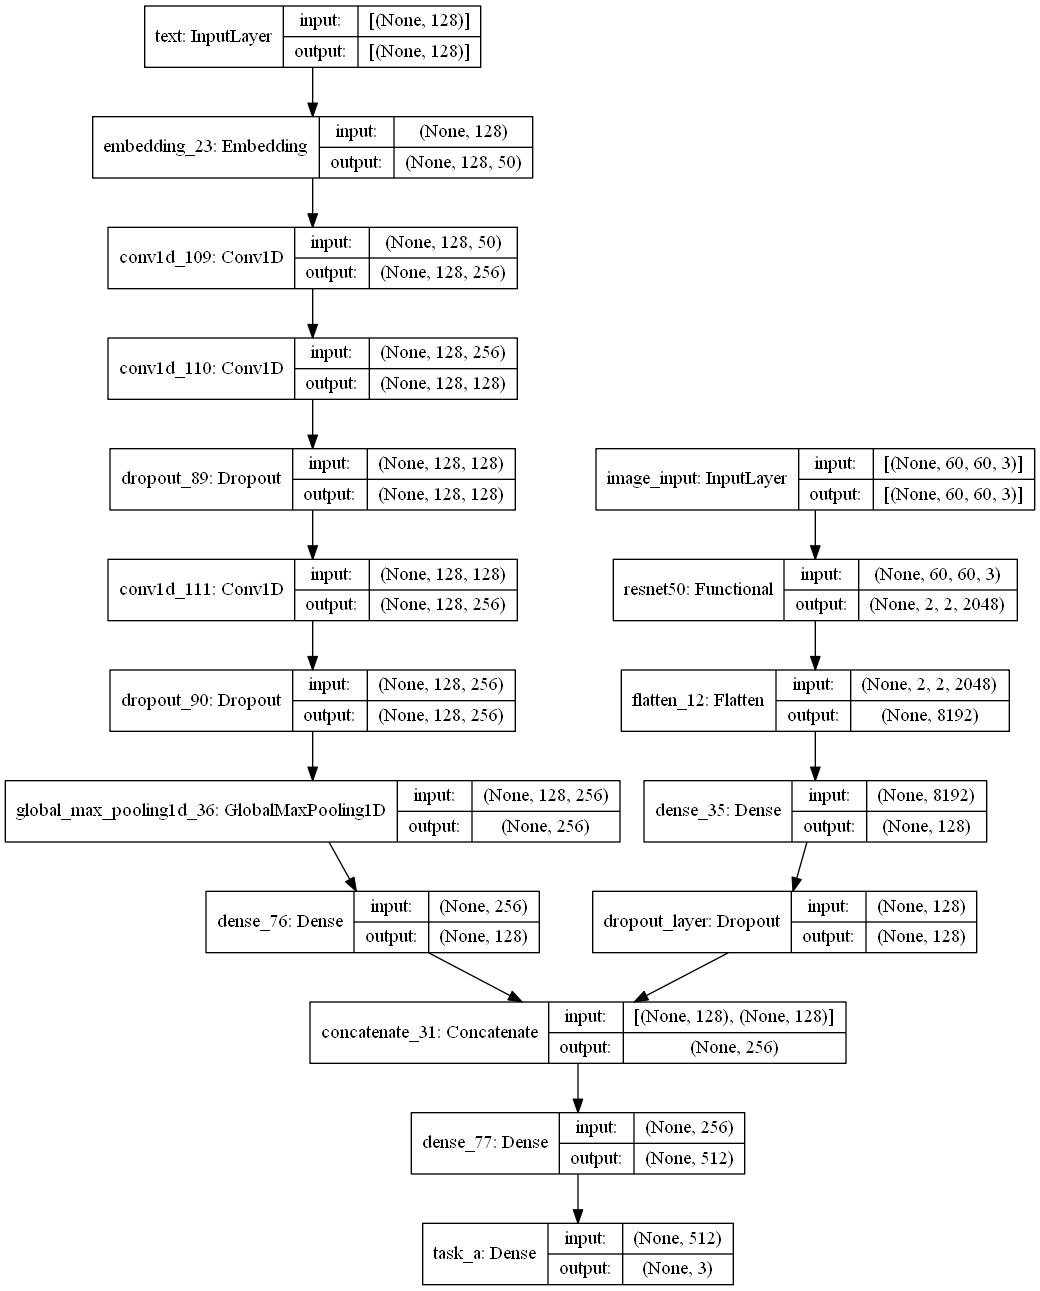

In [394]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [383]:
import os
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [384]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
    if epoch < 3:
        return 1e-1
    elif epoch >= 3 and epoch < 5:
        return 1e-2
    else:
        return 1e-5

In [385]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [386]:
np.array(X_train).shape

(9868, 60, 60, 3)

In [387]:
#X_train = tf.stack(X_train)
y_train = tf.stack(y_train)

In [398]:
np.array(y_train).shape

(9868, 3)

In [388]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = 'accuracy')

history = model.fit(x = {"image_input": np.array(X_train), "text": X_text_train},
                    y = y_train,
                    batch_size=128,
                    epochs=25,
                    callbacks=callbacks
                   )

Epoch 1/25


UnimplementedError:  Cast string to int32 is not supported
	 [[node model_27/embedding_23/Cast (defined at \AppData\Local\Temp/ipykernel_11256/1914015938.py:5) ]] [Op:__inference_train_function_76286]

Function call stack:
train_function


In [31]:
df_history = pd.DataFrame(history.history)
df_history

,loss,accuracy,lr
0,0.968716,0.583348,0.10000
1,0.901610,0.594808,0.10000
2,0.893178,0.594808,0.10000
3,0.891514,0.594808,0.01000
4,0.891384,0.594808,0.01000
5,0.891243,0.594808,0.00001
6,0.891271,0.594808,0.00001
7,0.891234,0.594808,0.00001
8,0.891254,0.594808,0.00001
9,0.891297,0.594808,0.00001


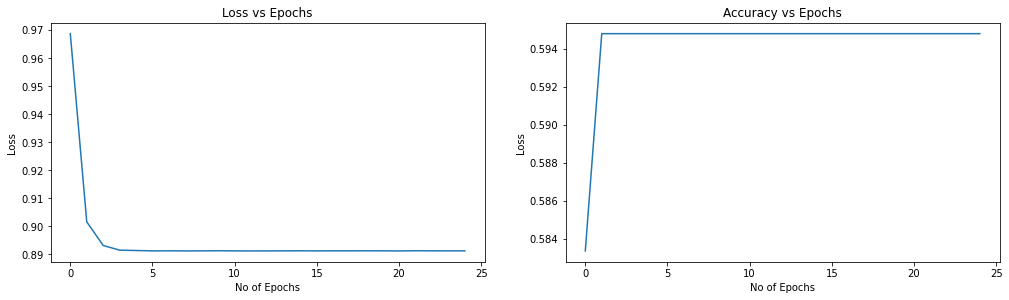

In [32]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.tight_layout(pad=5.0)

axes[0].plot(df_history.loss)
axes[0].set_xlabel('No of Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Epochs')

axes[1].plot(df_history.accuracy)
axes[1].set_xlabel('No of Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Accuracy vs Epochs')
plt.show()

In [33]:
eval_ = model.evaluate(x = {"image_input": X_test, "text": X_text_test},
                    y = y_test,
                    batch_size=32,
                    verbose=1
                   )

44/44 [==============================] - 8s 127ms/step - loss: 0.8910 - accuracy: 0.5948


In [34]:
prediction = model.predict(x = {"image_input": X_test, "text": X_text_test})
prediction = np.array(prediction)
prediction = np.squeeze(prediction)
prediction = 1/(1+np.exp(-np.array(prediction)))
prediction = np.where(prediction > 0.5, 1, 0)
y_true = y_test.values

micro_f1_score = f1_score(y_true[:,1], prediction[:,1], average='micro')
macro_f1_score = f1_score(y_true[:,1], prediction[:,1], average='macro')

print("Micro F1 score for Task A is ", micro_f1_score)
print("Macro F1 score for Task A is ", macro_f1_score)

Micro F1 score for Task A is  0.31496062992125984
Macro F1 score for Task A is  0.23952095808383236


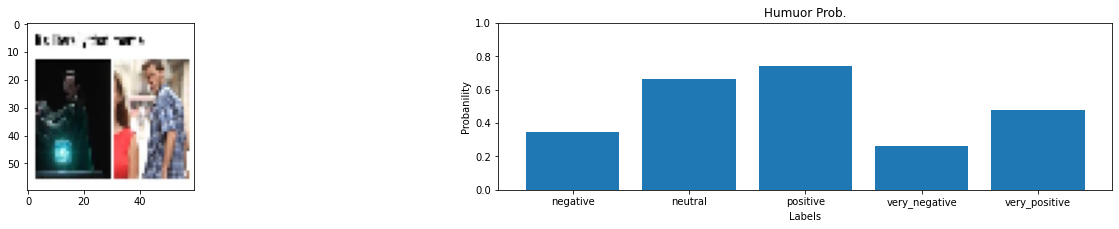

In [44]:
import random

fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

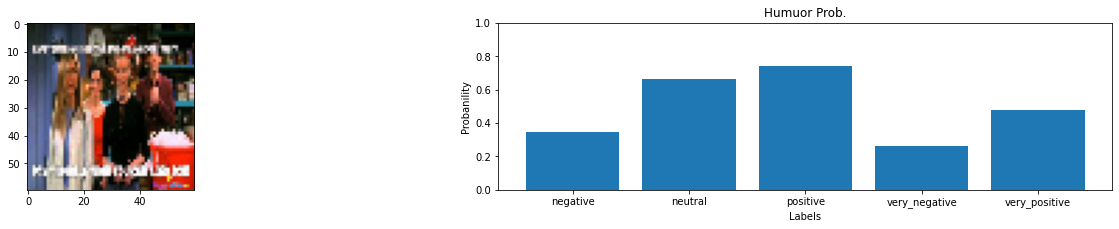

In [45]:
fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

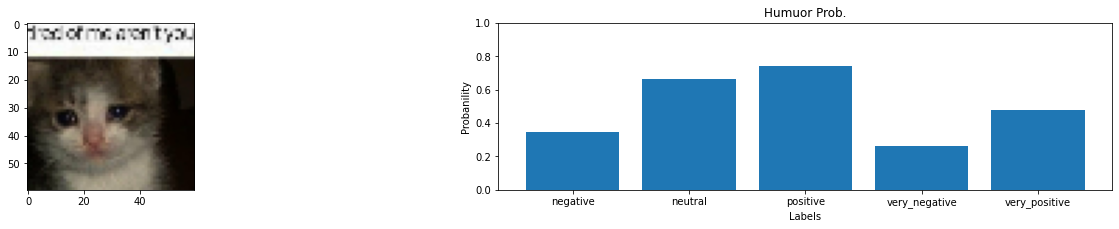

In [46]:
fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

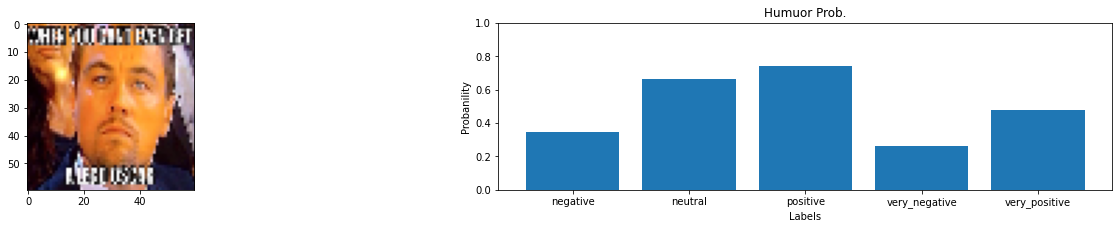

In [47]:
fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

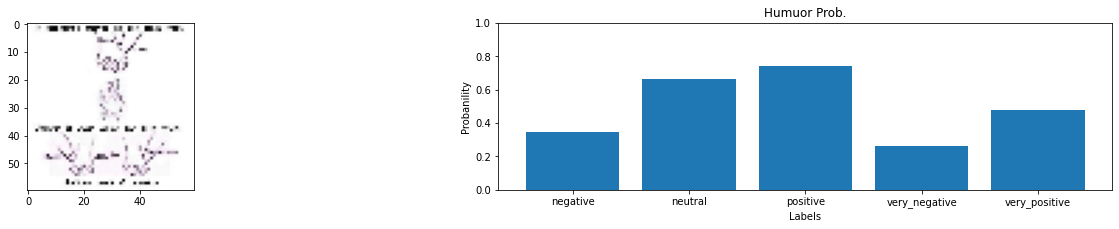

In [48]:
fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probanility')
axes[1].set_title('Humuor Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

In [ ]:
tensorflow.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)